# Práctica Texto

**Autor: Felipe Navarro**

**Mount drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

# Navigate to code directory
%cd /content/drive/My Drive/NLP

# List project directory contents
!ls

Mounted at /content/drive/
/content/drive/My Drive/NLP
 0_TEXT_IntroNLP.ipynb
 2a_TEXT_One-hot-encoding.ipynb
 2_TEXT_Wordnet.ipynb
 3a_TEXT_TFIDF-artist-favorite-word.ipynb
 3b_TEXT_LDA-Wikipedia-Example.ipynb
 3_TEXT_Sentiment_analysis_twitter.pdf
 3_TEXT_Sentiment_Analysis_Twitter.Rmd
 3_TEXT_WordCloud_Discurso_Del_Rey.ipynb
 4a_TEXT_intro_word_embeddings.ipynb
 4b_TEXT_word2vec-songs-recommendation.ipynb
 5a_TEXT_ML_SentimentAnalysis_IMBDmovie_reviews.ipynb
 5_TEXT_DenseNet_Classifying-IMBD-movie-reviews.ipynb
 6_TEXT_RNN_LSTM_Classifying_IMBD_movies_reviews.ipynb
 7_TEXT_TimeSeries_REE_electricity_demand_predictor.ipynb
 data
 generated
 LABS_NLP_Lesson_I
 LAB_TEXT_MachineTranslation_DE_EN.ipynb
'Optional_TopicModelling_Whatsapp-me-master.zip (Unzipped Files)'
 Practica_NLP
'TEXT _Requirements.docx'
 trained


### Import Required Libraries

In [2]:
import string
from pathlib import Path
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed, GRU, SimpleRNN, Activation
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth', 200)

### Read Data

English-Spanish sentence pairs

In [3]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

In [4]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [5]:
data = read_text("./Practica_NLP/spa.txt")
spa_eng = to_lines(data)
spa_eng = array(spa_eng)

In [ ]:
print("Hay {} pares de frases español-inglés".format(str(len(spa_eng))))

Hay 128084 pares de frases español-inglés


### Text Pre-Processing

#### Text Cleaning

Visualizamos los datos cargados

In [ ]:
spa_eng[0:5]

array([['Go.', 'Ve.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
       ['Go.', 'Vete.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'],
       ['Go.', 'Vaya.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'],
       ['Go.', 'Váyase.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #6586271 (arh)'],
       ['Hi.', 'Hola.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #431975 (Leono)']],
      dtype='<U278')

Eliminamos la tercera columna con la fuente de los datos

In [6]:
spa_eng = spa_eng[:,0:2]

Eliminar signos de puntuación y convertir a minúsculas

In [7]:
# Remove punctuation
spa_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,0]]
spa_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,1]]

La función anterior no elimina los signos ¡ y ¿ que son característicos del español, por lo que es necesario eliminar estos también

In [8]:
spa_eng[:,1] = [x.replace("¿","") for x in spa_eng[:,1]]

spa_eng[:,1] = [x.replace("¡","") for x in spa_eng[:,1]]

In [ ]:
spa_eng

array([['Go', 'Ve'],
       ['Go', 'Vete'],
       ['Go', 'Vaya'],
       ...,
       ['A carbon footprint is the amount of carbon dioxide pollution that we produce as a result of our activities Some people try to reduce their carbon footprint because they are concerned about climate change',
        'Una huella de carbono es la cantidad de contaminación de dióxido de carbono que producimos como producto de nuestras actividades Algunas personas intentan reducir su huella de carbono porque están preocupados acerca del cambio climático'],
       ['Since there are usually multiple websites on any given topic I usually just click the back button when I arrive on any webpage that has popup advertising I just go to the next page found by Google and hope for something less irritating',
        'Como suele haber varias páginas web sobre cualquier tema normalmente sólo le doy al botón de retroceso cuando entro en una página web que tiene anuncios en ventanas emergentes Simplemente voy a la sigu

In [9]:
# convert to lowercase
for i in range(len(spa_eng)):
    spa_eng[i,0] = spa_eng[i,0].lower()
    
    spa_eng[i,1] = spa_eng[i,1].lower()

In [ ]:
spa_eng

array([['go', 've'],
       ['go', 'vete'],
       ['go', 'vaya'],
       ...,
       ['a carbon footprint is the amount of carbon dioxide pollution that we produce as a result of our activities some people try to reduce their carbon footprint because they are concerned about climate change',
        'una huella de carbono es la cantidad de contaminación de dióxido de carbono que producimos como producto de nuestras actividades algunas personas intentan reducir su huella de carbono porque están preocupados acerca del cambio climático'],
       ['since there are usually multiple websites on any given topic i usually just click the back button when i arrive on any webpage that has popup advertising i just go to the next page found by google and hope for something less irritating',
        'como suele haber varias páginas web sobre cualquier tema normalmente sólo le doy al botón de retroceso cuando entro en una página web que tiene anuncios en ventanas emergentes simplemente voy a la sigu

#### Text to Sequence Conversion

Explorando la longitud de las frases en español y en inglés

In [10]:
# empty lists
eng_l = []
spa_l = []

# populate the lists with sentence lengths
for i in spa_eng[:,0]:
    eng_l.append(len(i.split()))

for i in spa_eng[:,1]:
    spa_l.append(len(i.split()))

In [11]:
length_df = pd.DataFrame({'eng':eng_l, 'spa':spa_l})
print(length_df)
print("Máxima longitud de frase en inglés: " + str(max(length_df.eng)))
print("Máxima longitud de frase en español: " + str(max(length_df.spa)))

        eng  spa
0         1    1
1         1    1
2         1    1
3         1    1
4         1    1
...     ...  ...
128079   31   35
128080   34   42
128081   34   35
128082   43   44
128083   47   49

[128084 rows x 2 columns]
Máxima longitud de frase en inglés: 47
Máxima longitud de frase en español: 49


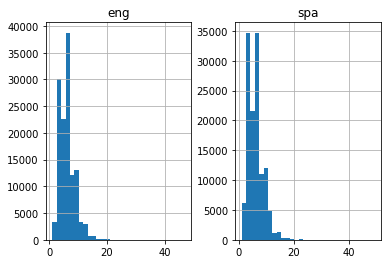

In [ ]:
length_df.hist(bins = 30)
plt.show()

Se puede observar como la gran mayoría de las frases están por debajo de las 15-20 palabras. Se filtra el dataframe por aquellas frases con una longitud menor de 16.

Generamos un dataframe con los pares de frases y las longitudes, que servirán para filtrar frases en función de la longitud de las mismas.

In [12]:
full_sentences_df = pd.DataFrame({"eng_txt":spa_eng[:,0],"spa_txt":spa_eng[:,1],'eng_l':eng_l, 'spa_l':spa_l})

In [ ]:
len(full_sentences_df)

128084

In [13]:
full_sentences_df = full_sentences_df[(full_sentences_df["spa_l"] < 16) & (full_sentences_df["eng_l"] < 16)]

In [ ]:
len(full_sentences_df)

126957

Una vez filtradas las frases con más de 15 palabras, se vuelve a explorar la distribución de la longitud de frase

In [14]:
length_df = full_sentences_df.iloc[:,2:]
print(length_df)
print("Máxima longitud de frase en inglés: " + str(max(length_df.eng_l)))
print("Máxima longitud de frase en español: " + str(max(length_df.spa_l)))

        eng_l  spa_l
0           1      1
1           1      1
2           1      1
3           1      1
4           1      1
...       ...    ...
127746     13     11
127800     15     14
127828     12     15
127857     15     15
127910     14     13

[126957 rows x 2 columns]
Máxima longitud de frase en inglés: 15
Máxima longitud de frase en español: 15


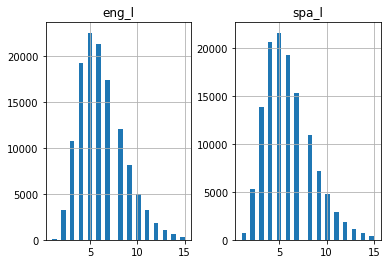

In [ ]:
length_df.hist(bins = 30)
plt.show()

Se puede apreciar que la mayoría de las frases tienen una longitud alredor de 5 palabras.

Se genera tambié un dataframe para frases con menos de 6 palabras, que servirá para entrenar el GRU y el simpleRNN

In [15]:
short_sentences_df = full_sentences_df[(full_sentences_df["spa_l"] < 6) & (full_sentences_df["eng_l"] < 6)]

In [ ]:
len(short_sentences_df)

48076

## **Trabajo con DF completo**

In [16]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [ ]:
# prepare english tokenizer
eng_tokenizer = tokenization(full_sentences_df.eng_txt.to_list())
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 15
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 13594


In [ ]:
# prepare spanish tokenizer
spa_tokenizer = tokenization(full_sentences_df.spa_txt.to_list())
spa_vocab_size = len(spa_tokenizer.word_index) + 1

spa_length = 15
print('Spanish Vocabulary Size: %d' % spa_vocab_size)

Spanish Vocabulary Size: 26418


Es importante destacar que el tamaño del vocabulario en español es aproximadamente el doble que tamaño del vocabulario en inglés.

In [ ]:
print(spa_tokenizer.word_counts)

OrderedDict([('ve', 241), ('vete', 53), ('vaya', 175), ('váyase', 8), ('hola', 39), ('corre', 40), ('corran', 4), ('corra', 3), ('corred', 4), ('quién', 1175), ('órale', 10), ('fuego', 134), ('incendio', 56), ('disparad', 3), ('ayuda', 451), ('socorro', 3), ('auxilio', 4), ('salta', 6), ('salte', 4), ('parad', 2), ('para', 4136), ('pare', 14), ('espera', 156), ('espérate', 1), ('esperen', 12), ('continúa', 22), ('continúe', 9), ('date', 20), ('prisa', 88), ('daos', 3), ('dese', 3), ('me', 8951), ('oculté', 1), ('escondí', 6), ('ocultaba', 1), ('escondía', 4), ('corrí', 19), ('corría', 12), ('lo', 7116), ('intento', 33), ('he', 1418), ('ganado', 40), ('oh', 21), ('no', 21831), ('tomátelo', 2), ('con', 5006), ('soda', 4), ('disparen', 1), ('dispara', 1), ('dispará', 1), ('dispare', 3), ('sonríe', 12), ('al', 3349), ('ataque', 27), ('atacad', 1), ('ataquen', 1), ('ataca', 2), ('levanta', 43), ('ahora', 1139), ('mismo', 563), ('id', 8), ('vayan', 24), ('ya', 1215), ('tengo', 2247), ('pilla

In [ ]:
print(eng_tokenizer.word_counts)

OrderedDict([('go', 3003), ('hi', 28), ('run', 220), ('who', 1479), ('wow', 10), ('fire', 244), ('help', 1384), ('jump', 28), ('stop', 570), ('wait', 425), ('on', 4359), ('hello', 31), ('hurry', 165), ('i', 29239), ('hid', 57), ('ran', 237), ('try', 438), ('won', 113), ('oh', 24), ('no', 1817), ('relax', 46), ('shoot', 29), ('smile', 87), ('attack', 50), ('get', 2036), ('up', 2158), ('now', 1337), ('got', 1254), ('it', 7757), ('he', 10256), ('hop', 1), ('in', 8893), ('hug', 24), ('me', 6987), ('care', 334), ('fell', 201), ('fled', 10), ('know', 3710), ('left', 687), ('lied', 70), ('lost', 520), ('paid', 141), ('quit', 132), ('sang', 53), ('wept', 6), ('work', 1076), ('im', 4370), ('19', 5), ('listen', 189), ('way', 672), ('really', 981), ('thanks', 122), ('we', 4580), ('ate', 260), ('why', 1689), ('ask', 549), ('tom', 20913), ('him', 3020), ('awesome', 14), ('be', 4360), ('calm', 62), ('cool', 52), ('fair', 44), ('good', 1627), ('kind', 327), ('nice', 255), ('beat', 75), ('call', 533),

Preparar secuencias y hacer padding

In [17]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    print(seq)
    print(len(seq))
    return seq

### Model Building

Split training-test

In [ ]:
spa_eng = [[row.eng_txt,row.spa_txt] for index,row in full_sentences_df.iterrows()]

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(full_sentences_df, test_size=0.2, random_state = 12)

Encode-Decode

*   Encode: Frases en español
*   Decode: Frases en inglés


In [ ]:
# prepare training data
trainX = encode_sequences(spa_tokenizer, spa_length, train.iloc[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train.iloc[:, 0])

[[  86  205  206 ...    0    0    0]
 [   3   11   49 ...    0    0    0]
 [   4   24   23 ...    0    0    0]
 ...
 [  26   12 7610 ...    0    0    0]
 [   5  229  104 ...    0    0    0]
 [  76    8   10 ...    0    0    0]]
101565
[[  14    4   18 ...    0    0    0]
 [   1   61   60 ...    0    0    0]
 [  21    7 1261 ...    0    0    0]
 ...
 [  24  422  193 ...    0    0    0]
 [   5   72   31 ...    0    0    0]
 [  12    7    6 ...    0    0    0]]
101565


In [ ]:
print(trainX.shape)
print(trainY.shape)

(101565, 15)
(101565, 15)


In [ ]:
# prepare validation data
testX = encode_sequences(spa_tokenizer, spa_length, test.iloc[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test.iloc[:, 0])

[[   5    3  134 ...    0    0    0]
 [  15   17 6287 ...    0    0    0]
 [  15  117   95 ...    0    0    0]
 ...
 [  14   65  151 ...    0    0    0]
 [ 483    3  659 ...    0    0    0]
 [  41    7   89 ...    0    0    0]]
25392
[[   5   55   18 ...    0    0    0]
 [ 132 7234    0 ...    0    0    0]
 [   8    7  273 ...    0    0    0]
 ...
 [  92  237   12 ...    0    0    0]
 [   4   18   66 ...    0    0    0]
 [   1   18    2 ...    0    0    0]]
25392


In [ ]:
print(testX.shape)
print(testY.shape)

(25392, 15)
(25392, 15)


## **LSTM**


In [ ]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [ ]:
print(spa_vocab_size)
print(eng_vocab_size)
print(spa_length)
print(eng_length)

26418
13594
15
15


In [ ]:
model = build_model(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [27]:
checkpoint_dir = "./Practica_NLP/checkpoints/"

Path(checkpoint_dir).mkdir(exist_ok=True, parents=True)


In [ ]:
filename = checkpoint_dir + 'lstm_mbd_may_21'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=20, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/20
159/159 [==============================] - 1813s 11s/step - loss: 3.6093 - val_loss: 2.7118

Epoch 00001: val_loss improved from inf to 2.71180, saving model to ./Practica_NLP/checkpoints/lstm_mbd_may_21


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/lstm_mbd_may_21/assets


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/lstm_mbd_may_21/assets


Epoch 2/20
159/159 [==============================] - 1824s 11s/step - loss: 2.6128 - val_loss: 2.5286

Epoch 00002: val_loss improved from 2.71180 to 2.52865, saving model to ./Practica_NLP/checkpoints/lstm_mbd_may_21


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/lstm_mbd_may_21/assets


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/lstm_mbd_may_21/assets


Epoch 3/20
159/159 [==============================] - 1838s 12s/step - loss: 2.4366 - val_loss: 2.3500

Epoch 00003: val_loss improved from 2.52865 to 2.35001, saving model to ./Practica_NLP/checkpoints/lstm_mbd_may_21


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/lstm_mbd_may_21/assets


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/lstm_mbd_may_21/assets


Epoch 4/20
159/159 [==============================] - 1854s 12s/step - loss: 2.2665 - val_loss: 2.2082

Epoch 00004: val_loss improved from 2.35001 to 2.20818, saving model to ./Practica_NLP/checkpoints/lstm_mbd_may_21


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/lstm_mbd_may_21/assets


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/lstm_mbd_may_21/assets


Epoch 5/20
159/159 [==============================] - 1849s 12s/step - loss: 2.1028 - val_loss: 2.0736

Epoch 00005: val_loss improved from 2.20818 to 2.07364, saving model to ./Practica_NLP/checkpoints/lstm_mbd_may_21


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/lstm_mbd_may_21/assets


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/lstm_mbd_may_21/assets


Epoch 6/20
159/159 [==============================] - 1855s 12s/step - loss: 1.9512 - val_loss: 1.9473

Epoch 00006: val_loss improved from 2.07364 to 1.94733, saving model to ./Practica_NLP/checkpoints/lstm_mbd_may_21


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/lstm_mbd_may_21/assets


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/lstm_mbd_may_21/assets


Epoch 7/20
159/159 [==============================] - 1844s 12s/step - loss: 1.8093 - val_loss: 1.8410

Epoch 00007: val_loss improved from 1.94733 to 1.84096, saving model to ./Practica_NLP/checkpoints/lstm_mbd_may_21


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/lstm_mbd_may_21/assets


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/lstm_mbd_may_21/assets


Epoch 8/20
159/159 [==============================] - 1852s 12s/step - loss: 1.6761 - val_loss: 1.7560

Epoch 00008: val_loss improved from 1.84096 to 1.75604, saving model to ./Practica_NLP/checkpoints/lstm_mbd_may_21


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/lstm_mbd_may_21/assets


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/lstm_mbd_may_21/assets


Epoch 9/20
159/159 [==============================] - 1851s 12s/step - loss: 1.5605 - val_loss: 1.6854

Epoch 00009: val_loss improved from 1.75604 to 1.68537, saving model to ./Practica_NLP/checkpoints/lstm_mbd_may_21


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/lstm_mbd_may_21/assets


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/lstm_mbd_may_21/assets


Epoch 10/20
159/159 [==============================] - 1855s 12s/step - loss: 1.4421 - val_loss: 1.6124

Epoch 00010: val_loss improved from 1.68537 to 1.61240, saving model to ./Practica_NLP/checkpoints/lstm_mbd_may_21


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/lstm_mbd_may_21/assets


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/lstm_mbd_may_21/assets


Epoch 11/20
159/159 [==============================] - 1850s 12s/step - loss: 1.3525 - val_loss: 1.5636

Epoch 00011: val_loss improved from 1.61240 to 1.56356, saving model to ./Practica_NLP/checkpoints/lstm_mbd_may_21


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/lstm_mbd_may_21/assets


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/lstm_mbd_may_21/assets


Epoch 12/20
159/159 [==============================] - 1854s 12s/step - loss: 1.2597 - val_loss: 1.5247

Epoch 00012: val_loss improved from 1.56356 to 1.52473, saving model to ./Practica_NLP/checkpoints/lstm_mbd_may_21


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/lstm_mbd_may_21/assets


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/lstm_mbd_may_21/assets


Epoch 13/20
159/159 [==============================] - 1856s 12s/step - loss: 1.1760 - val_loss: 1.5084

Epoch 00013: val_loss improved from 1.52473 to 1.50840, saving model to ./Practica_NLP/checkpoints/lstm_mbd_may_21


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/lstm_mbd_may_21/assets


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/lstm_mbd_may_21/assets


Epoch 14/20
159/159 [==============================] - 1857s 12s/step - loss: 1.1047 - val_loss: 1.4706

Epoch 00014: val_loss improved from 1.50840 to 1.47057, saving model to ./Practica_NLP/checkpoints/lstm_mbd_may_21


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/lstm_mbd_may_21/assets


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/lstm_mbd_may_21/assets


Epoch 15/20
159/159 [==============================] - 1848s 12s/step - loss: 1.0325 - val_loss: 1.4352

Epoch 00015: val_loss improved from 1.47057 to 1.43518, saving model to ./Practica_NLP/checkpoints/lstm_mbd_may_21


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/lstm_mbd_may_21/assets


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/lstm_mbd_may_21/assets


Epoch 16/20
159/159 [==============================] - 1852s 12s/step - loss: 0.9682 - val_loss: 1.4369

Epoch 00016: val_loss did not improve from 1.43518
Epoch 17/20
159/159 [==============================] - 1849s 12s/step - loss: 0.9084 - val_loss: 1.4115

Epoch 00017: val_loss improved from 1.43518 to 1.41146, saving model to ./Practica_NLP/checkpoints/lstm_mbd_may_21


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/lstm_mbd_may_21/assets


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/lstm_mbd_may_21/assets


Epoch 18/20
159/159 [==============================] - 1851s 12s/step - loss: 0.8476 - val_loss: 1.4046

Epoch 00018: val_loss improved from 1.41146 to 1.40461, saving model to ./Practica_NLP/checkpoints/lstm_mbd_may_21


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/lstm_mbd_may_21/assets


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/lstm_mbd_may_21/assets


Epoch 19/20
159/159 [==============================] - 1851s 12s/step - loss: 0.7927 - val_loss: 1.4063

Epoch 00019: val_loss did not improve from 1.40461
Epoch 20/20
159/159 [==============================] - 1851s 12s/step - loss: 0.7446 - val_loss: 1.4090

Epoch 00020: val_loss did not improve from 1.40461


Loss training vs. validation

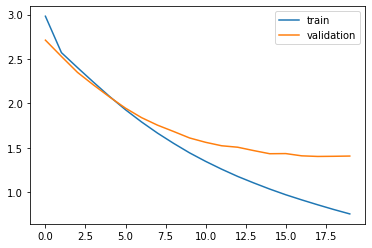

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

El entrenamiento del modelo ha llevado 10 horas, dada la gran cantidad de datos introducidos en el mismo.

El loss en validación parece estancarse a partir de la época 18, a pesar de que el loss de entrenamiento continúa descendiendo.

Hay un claro sobreentrenamiento a partir de la época 5

### Make Predictions

Cargar modelo y hacer predicciones

In [ ]:
model = load_model(filename)

Es necesario cargar un mini_batch para hacer predict, pues de lo contrario se agota toda la memoria RAM disponible

In [ ]:
testX1 = testX[0:100]

In [ ]:
preds = model.predict_classes(testX1.reshape((testX1.shape[0],testX1.shape[1])),batch_size=8)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [18]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [ ]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [ ]:
pred_df = pd.DataFrame({'actual' : test.iloc[0:100,0], 'predicted' : preds_text})

In [ ]:
pd.set_option('display.max_colwidth', 200)

In [ ]:
pred_df.head(15)

,actual,predicted
120343,tom didnt have enough experience to do the job well,tom didnt have enough to do job
4542,hes demented,hes adorable
82320,he is able to speak ten languages,he knows able to languages
26924,im living in boston,i live in boston
76806,this stool needs to be repaired,this problem is to a fixed
18141,i cant blame them,i cant blame you
59120,that picture will amuse you,that movie makes a lot
100726,i want to speak to the person in charge,i want to talk to the person
39419,i do not play the piano,i dont play the piano
75789,it would be good if i had a car,well as how if i have a


In [ ]:
pred_df.tail(15)

,actual,predicted
119983,i think its time for me to split some more firewood,i think its time for me to more some more
45406,owls are active at night,prices are at
66190,how many watches did tom lose,how many old did tom
91566,we stood on the top of the mountain,we were up in the
86106,how many trees are in your orchard,how many people are there in your
104914,hes the boy we spoke about the other day,he is the boy who to the class
90334,my sister has become a good pianist,my father became a dress
126173,we dont need any more volunteers but we could use some more money,we dont need any but we have more
76105,poverty is the root of all evil,compared is the wealth luck of
19470,she made him do it,she did him do it


In [ ]:
pred_df.sample(15)

,actual,predicted
38364,youd better go to bed,youd better in
117865,tom made it quite clear what he expected us to do,tom did it what to
120343,tom didnt have enough experience to do the job well,tom didnt have enough to do job
32453,this coffee is bitter,this coffee is hot
49249,id like some more butter,id like some more
119983,i think its time for me to split some more firewood,i think its time for me to more some more
88494,what do you have on the menu today,what do you have at christmas
20839,whos this box for,which is this
125605,tom is able to say i can only speak french in thirty languages,tom can talk sure he can in
39419,i do not play the piano,i dont play the piano


La calidad de las traducciones no es especialmente buena. El modelo tiene problemas para generar frases largas y muchas de las frases que genera carecen de sentido.

Se va a tratar de mejorar este modelo, utilizando frases más cortas y otras configuraciones para el modelo.

## **Trabajo con frases cortas**

Dado que el GRU básico y el SimpleRNN no trabajan bien con secuencias largas, se va a trabajar con frases de longitud máxima 5.

Además, de este modo se reduce el número de muestras, lo que acorta el tiempo de entrenamiento

In [19]:
# prepare english tokenizer
eng_tokenizer = tokenization(short_sentences_df.eng_txt.to_list())
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 5
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 7573


In [20]:
# prepare spanish tokenizer
spa_tokenizer = tokenization(short_sentences_df.spa_txt.to_list())
spa_vocab_size = len(spa_tokenizer.word_index) + 1

spa_length = 5
print('Spanish Vocabulary Size: %d' % spa_vocab_size)

Spanish Vocabulary Size: 14182


In [ ]:
print(spa_tokenizer.word_counts)

OrderedDict([('ve', 125), ('vete', 40), ('vaya', 26), ('váyase', 7), ('hola', 26), ('corre', 17), ('corran', 2), ('corra', 1), ('corred', 2), ('quién', 578), ('órale', 10), ('fuego', 36), ('incendio', 5), ('disparad', 3), ('ayuda', 155), ('socorro', 2), ('auxilio', 2), ('salta', 2), ('salte', 2), ('parad', 2), ('para', 401), ('pare', 4), ('espera', 73), ('espérate', 1), ('esperen', 10), ('continúa', 15), ('continúe', 7), ('date', 6), ('prisa', 27), ('daos', 2), ('dese', 2), ('me', 2616), ('oculté', 1), ('escondí', 1), ('ocultaba', 1), ('escondía', 1), ('corrí', 9), ('corría', 5), ('lo', 1683), ('intento', 10), ('he', 431), ('ganado', 18), ('oh', 8), ('no', 5806), ('tomátelo', 2), ('con', 665), ('soda', 2), ('disparen', 1), ('dispara', 1), ('dispará', 1), ('dispare', 3), ('sonríe', 5), ('al', 467), ('ataque', 5), ('atacad', 1), ('ataquen', 1), ('ataca', 1), ('levanta', 17), ('ahora', 421), ('mismo', 116), ('id', 7), ('vayan', 10), ('ya', 437), ('tengo', 669), ('pillas', 1), ('entendiste

In [ ]:
print(eng_tokenizer.word_counts)

OrderedDict([('go', 739), ('hi', 21), ('run', 62), ('who', 449), ('wow', 8), ('fire', 62), ('help', 392), ('jump', 12), ('stop', 303), ('wait', 181), ('on', 757), ('hello', 12), ('hurry', 63), ('i', 8053), ('hid', 8), ('ran', 79), ('try', 171), ('won', 59), ('oh', 10), ('no', 495), ('relax', 23), ('shoot', 17), ('smile', 21), ('attack', 13), ('get', 491), ('up', 533), ('now', 502), ('got', 406), ('it', 2713), ('he', 2318), ('hop', 1), ('in', 1037), ('hug', 13), ('me', 2017), ('care', 45), ('fell', 42), ('fled', 5), ('know', 697), ('left', 153), ('lied', 33), ('lost', 210), ('paid', 33), ('quit', 50), ('sang', 28), ('wept', 6), ('work', 289), ('im', 1936), ('19', 3), ('listen', 88), ('way', 98), ('really', 335), ('thanks', 89), ('we', 1535), ('ate', 88), ('why', 420), ('ask', 117), ('tom', 6220), ('him', 663), ('awesome', 10), ('be', 930), ('calm', 32), ('cool', 33), ('fair', 24), ('good', 488), ('kind', 47), ('nice', 109), ('beat', 20), ('call', 196), ('us', 347), ('come', 572), ('drop

### Model Building

In [ ]:
spa_eng = [[row.eng_txt,row.spa_txt] for index,row in short_sentences_df.iterrows()]

In [21]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(short_sentences_df, test_size=0.2, random_state = 12)

In [22]:
# prepare training data
trainX = encode_sequences(spa_tokenizer, spa_length, train.iloc[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train.iloc[:, 0])

[[  43    8  165 2208    0]
 [  37  399    3 6613    0]
 [ 303  124    1    3  367]
 ...
 [   1 2022   24 1726    0]
 [2059   17 1502    0    0]
 [  51    7  450    0    0]]
38460
[[   8   14    6  308  214]
 [  10  491    4 2134    0]
 [ 465    3    4  305    0]
 ...
 [   3  262    5 1443    0]
 [   1 1024   53 1354    0]
 [ 151  309   11    0    0]]
38460


In [ ]:
print(trainX.shape)
print(trainY.shape)

(38460, 5)
(38460, 5)


In [23]:
# prepare validation data
testX = encode_sequences(spa_tokenizer, spa_length, test.iloc[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test.iloc[:, 0])

[[   5 2947  595   18   65]
 [  67  330   20 1061    0]
 [   2   34 1120    0    0]
 ...
 [  38  396    0    0    0]
 [ 109 4167   56  665    0]
 [ 221  661   53    0    0]]
9616
[[2595 2944   64  115    0]
 [   1 2806  492   15  176]
 [   1   18   19    6 1034]
 ...
 [  28    1   50   26    0]
 [  36    2  147  637  135]
 [  28    2  467   71    0]]
9616


In [ ]:
print(testX.shape)
print(testY.shape)

(9616, 5)
(9616, 5)


## LSTM con frases cortas


In [ ]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [ ]:
model = build_model(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
filename = checkpoint_dir + 'adv_lstm_may_21'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=15, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/15
61/61 [==============================] - 189s 3s/step - loss: 6.3752 - accuracy: 0.2026 - val_loss: 5.3098 - val_accuracy: 0.2391

Epoch 00001: val_loss improved from inf to 5.30979, saving model to ./Practica_NLP/checkpoints/adv_lstm_may_21


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/adv_lstm_may_21/assets


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/adv_lstm_may_21/assets


Epoch 2/15
61/61 [==============================] - 180s 3s/step - loss: 4.9985 - accuracy: 0.2525 - val_loss: 4.9372 - val_accuracy: 0.2595

Epoch 00002: val_loss improved from 5.30979 to 4.93722, saving model to ./Practica_NLP/checkpoints/adv_lstm_may_21


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/adv_lstm_may_21/assets


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/adv_lstm_may_21/assets


Epoch 3/15
61/61 [==============================] - 180s 3s/step - loss: 4.7361 - accuracy: 0.2773 - val_loss: 4.7140 - val_accuracy: 0.2848

Epoch 00003: val_loss improved from 4.93722 to 4.71399, saving model to ./Practica_NLP/checkpoints/adv_lstm_may_21


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/adv_lstm_may_21/assets


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/adv_lstm_may_21/assets


Epoch 4/15
61/61 [==============================] - 179s 3s/step - loss: 4.4853 - accuracy: 0.3014 - val_loss: 4.5279 - val_accuracy: 0.3059

Epoch 00004: val_loss improved from 4.71399 to 4.52793, saving model to ./Practica_NLP/checkpoints/adv_lstm_may_21


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/adv_lstm_may_21/assets


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/adv_lstm_may_21/assets


Epoch 5/15
61/61 [==============================] - 180s 3s/step - loss: 4.2602 - accuracy: 0.3207 - val_loss: 4.3851 - val_accuracy: 0.3190

Epoch 00005: val_loss improved from 4.52793 to 4.38514, saving model to ./Practica_NLP/checkpoints/adv_lstm_may_21


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/adv_lstm_may_21/assets


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/adv_lstm_may_21/assets


Epoch 6/15
61/61 [==============================] - 180s 3s/step - loss: 4.0697 - accuracy: 0.3388 - val_loss: 4.2724 - val_accuracy: 0.3345

Epoch 00006: val_loss improved from 4.38514 to 4.27239, saving model to ./Practica_NLP/checkpoints/adv_lstm_may_21


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/adv_lstm_may_21/assets


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/adv_lstm_may_21/assets


Epoch 7/15
61/61 [==============================] - 179s 3s/step - loss: 3.8708 - accuracy: 0.3570 - val_loss: 4.1554 - val_accuracy: 0.3496

Epoch 00007: val_loss improved from 4.27239 to 4.15537, saving model to ./Practica_NLP/checkpoints/adv_lstm_may_21


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/adv_lstm_may_21/assets


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/adv_lstm_may_21/assets


Epoch 8/15
61/61 [==============================] - 180s 3s/step - loss: 3.6757 - accuracy: 0.3783 - val_loss: 4.0085 - val_accuracy: 0.3666

Epoch 00008: val_loss improved from 4.15537 to 4.00854, saving model to ./Practica_NLP/checkpoints/adv_lstm_may_21


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/adv_lstm_may_21/assets


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/adv_lstm_may_21/assets


Epoch 9/15
61/61 [==============================] - 180s 3s/step - loss: 3.4791 - accuracy: 0.4000 - val_loss: 3.8639 - val_accuracy: 0.3870

Epoch 00009: val_loss improved from 4.00854 to 3.86391, saving model to ./Practica_NLP/checkpoints/adv_lstm_may_21


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/adv_lstm_may_21/assets


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/adv_lstm_may_21/assets


Epoch 10/15
61/61 [==============================] - 179s 3s/step - loss: 3.2925 - accuracy: 0.4235 - val_loss: 3.7772 - val_accuracy: 0.3966

Epoch 00010: val_loss improved from 3.86391 to 3.77722, saving model to ./Practica_NLP/checkpoints/adv_lstm_may_21


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/adv_lstm_may_21/assets


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/adv_lstm_may_21/assets


Epoch 11/15
61/61 [==============================] - 180s 3s/step - loss: 3.1062 - accuracy: 0.4408 - val_loss: 3.6393 - val_accuracy: 0.4190

Epoch 00011: val_loss improved from 3.77722 to 3.63929, saving model to ./Practica_NLP/checkpoints/adv_lstm_may_21


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/adv_lstm_may_21/assets


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/adv_lstm_may_21/assets


Epoch 12/15
61/61 [==============================] - 180s 3s/step - loss: 2.9392 - accuracy: 0.4594 - val_loss: 3.5760 - val_accuracy: 0.4250

Epoch 00012: val_loss improved from 3.63929 to 3.57597, saving model to ./Practica_NLP/checkpoints/adv_lstm_may_21


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/adv_lstm_may_21/assets


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/adv_lstm_may_21/assets


Epoch 13/15
61/61 [==============================] - 180s 3s/step - loss: 2.7736 - accuracy: 0.4764 - val_loss: 3.5432 - val_accuracy: 0.4379

Epoch 00013: val_loss improved from 3.57597 to 3.54323, saving model to ./Practica_NLP/checkpoints/adv_lstm_may_21


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/adv_lstm_may_21/assets


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/adv_lstm_may_21/assets


Epoch 14/15
61/61 [==============================] - 181s 3s/step - loss: 2.6417 - accuracy: 0.4927 - val_loss: 3.4429 - val_accuracy: 0.4472

Epoch 00014: val_loss improved from 3.54323 to 3.44293, saving model to ./Practica_NLP/checkpoints/adv_lstm_may_21


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/adv_lstm_may_21/assets


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/adv_lstm_may_21/assets


Epoch 15/15
61/61 [==============================] - 180s 3s/step - loss: 2.4887 - accuracy: 0.5092 - val_loss: 3.3882 - val_accuracy: 0.4492

Epoch 00015: val_loss improved from 3.44293 to 3.38818, saving model to ./Practica_NLP/checkpoints/adv_lstm_may_21


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/adv_lstm_may_21/assets


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/adv_lstm_may_21/assets


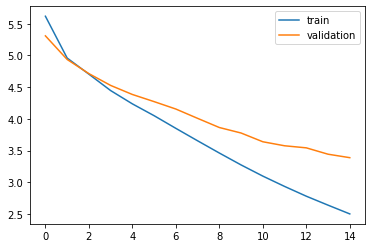

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

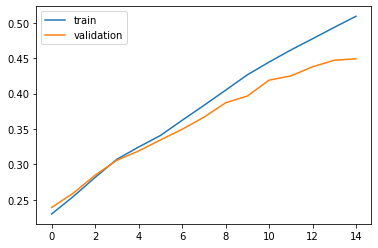

In [ ]:
# Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train','validation'])
plt.show()

In [34]:
testX1 = testX[0:100]

In [ ]:
model = load_model(filename)
preds = model.predict_classes(testX1.reshape((testX1.shape[0],testX1.shape[1])),batch_size=8)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [ ]:
pred_df = pd.DataFrame({'actual' : test.iloc[0:100,0], 'predicted' : preds_text})

In [ ]:
pd.set_option('display.max_colwidth', 200)

In [ ]:
pred_df.head(15)

,actual,predicted
43313,education starts at home,the was
22619,i wanna quit my job,i want this your
48635,i dont have a flashlight,i dont have a
39235,hold it with both hands,were out your shoes
23356,my sister is famous,my mother is good
27631,shes gone on a trip,she was a
51179,tom turned his lights off,tom took off his bank
33033,we defeated the enemy,we the
30658,i just want the facts,i dont want to
15404,is somebody there,is


In [ ]:
pred_df.tail(15)

,actual,predicted
21325,can i see you again,i go you
20085,tom has three cars,tom has three
19261,my boots are dusty,my parents were in
50281,thatll be enough for now,nobody one be anything
13494,tom dont leave,dont help
55520,tom wanted to protect mary,tom wants to mary
36048,its strange isnt it,hes is really
83660,lets start with something simple,lets go to about
2224,im not fat,im not fat
44355,i made a serious mistake,i have a


In [ ]:
pred_df.sample(15)

,actual,predicted
17111,why are you angry,why are you
2224,im not fat,im not fat
13494,tom dont leave,dont help
4980,i smell smoke,i love
33547,you may take the book,you use the car
3141,i cut myself,i have lost
41281,the floor was very cold,the boy was very
16992,when is the party,where does the this
9338,im leaving now,were in the
67476,my brother became an engineer,my father was a


El tiempo de entrenamiento ha sido sustancialmente menor que en el caso anterior (1,5h frente a 10h), al haber menos datos y ser las frases más cortas.

No obstante, en este caso el modelo tiene un loss notablemente mayor que en el que se entrenaba con todas las frases. Las traducciones reflejan este valor elevado del loss, careciendo de sentido en muchos casos.

## **GRU**

In [24]:
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(GRU(units, dropout=0.2, recurrent_dropout=0.3, return_sequences=True))
    model.add(GRU(units, dropout=0.2, recurrent_dropout=0.3, return_sequences=True))
    model.add(TimeDistributed(Dense(out_vocab,activation='softmax')))
    return model

In [25]:
model = build_model(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [28]:
filename = checkpoint_dir + 'gru_mbd_may_21'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=15, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/15
61/61 [==============================] - 212s 3s/step - loss: 5.1150 - accuracy: 0.0983 - val_loss: 4.0079 - val_accuracy: 0.1702

Epoch 00001: val_loss improved from inf to 4.00791, saving model to ./Practica_NLP/checkpoints/gru_mbd_may_21
INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/gru_mbd_may_21/assets
Epoch 2/15
61/61 [==============================] - 206s 3s/step - loss: 3.7981 - accuracy: 0.1958 - val_loss: 3.5728 - val_accuracy: 0.2413

Epoch 00002: val_loss improved from 4.00791 to 3.57285, saving model to ./Practica_NLP/checkpoints/gru_mbd_may_21
INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/gru_mbd_may_21/assets
Epoch 3/15
61/61 [==============================] - 203s 3s/step - loss: 3.3098 - accuracy: 0.2755 - val_loss: 3.2456 - val_accuracy: 0.3106

Epoch 00003: val_loss improved from 3.57285 to 3.24560, saving model to ./Practica_NLP/checkpoints/gru_mbd_may_21
INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/gru_mb

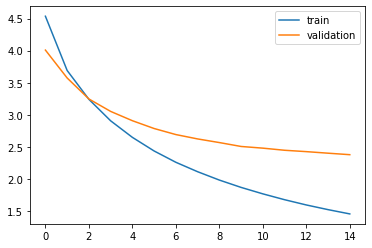

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

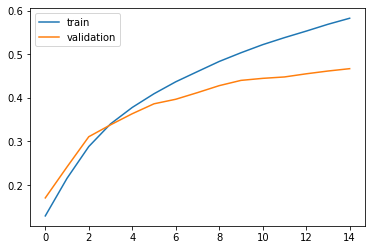

In [30]:
# Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train','validation'])
plt.show()

En este modelo se ha conseguido un accuracy mayor y un loss menor, pero el overfitting sigue siendo un problema evidente.


In [35]:
model = load_model(filename)
preds = model.predict_classes(testX1.reshape((testX1.shape[0],testX1.shape[1])),batch_size=8)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [36]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [37]:
pred_df = pd.DataFrame({'actual' : test.iloc[0:100,0], 'predicted' : preds_text})

In [38]:
pd.set_option('display.max_colwidth', 200)

In [40]:
pred_df.head(15)

,actual,predicted
43313,education starts at home,the is exist in
22619,i wanna quit my job,i want my
48635,i dont have a flashlight,i dont have
39235,hold it with both hands,get out up hands
23356,my sister is famous,my sister is famous
27631,shes gone on a trip,she got gone
51179,tom turned his lights off,tom turned his look
33033,we defeated the enemy,get on the
30658,i just want the facts,i just want
15404,is somebody there,is someone


In [39]:
pred_df.tail(15)

,actual,predicted
21325,can i see you again,can i go to
20085,tom has three cars,tom has three older
19261,my boots are dusty,my sweater have
50281,thatll be enough for now,that will enough
13494,tom dont leave,i dont go tom
55520,tom wanted to protect mary,tom wanted to mary
36048,its strange isnt it,its strange not
83660,lets start with something simple,lets talk something a
2224,im not fat,i not fat
44355,i made a serious mistake,i had a mistake


In [41]:
pred_df.sample(15)

,actual,predicted
26914,im here to save you,im here to eat
11805,i have a grenade,i have a
48635,i dont have a flashlight,i dont have
31882,she and i are cousins,she and i are cousins
2031,i got angry,i hurt
24409,tom needs something,tom needs a
15125,i tried to escape,i tried
19819,they were soldiers,were
5237,it takes time,this beer his time
17339,youre not stupid,i not stupid


A pesar de obtener un mayor accuracy y un menor loss que en el caso anterior, las traducciones siguen sin ser buenas (muchas de ellas carecen de sentido)

Por otro lado, este modelo entrena considerablemente más rápido (aprox. 45 minutos frente a 90 del modelo anterior)

## **Simple RNN**

In [ ]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(units, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # This last layer only returns the last outputs.
model.add(TimeDistributed(Dense(out_vocab,activation='softmax')))
model.summary()

In [ ]:
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(SimpleRNN(units,dropout=0.2, recurrent_dropout=0.3, return_sequences=True))
    model.add(SimpleRNN(units,dropout=0.2, recurrent_dropout=0.3, return_sequences=True))
    model.add(SimpleRNN(units,dropout=0.2, recurrent_dropout=0.3, return_sequences=True))
    model.add(TimeDistributed(Dense(out_vocab,activation='softmax')))
    return model

In [ ]:
model = build_model(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
filename = checkpoint_dir + 'simpleRNN_mbd_may_21'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=15, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/15
61/61 [==============================] - 153s 2s/step - loss: 4.9031 - accuracy: 0.1073 - val_loss: 4.0050 - val_accuracy: 0.1887

Epoch 00001: val_loss improved from inf to 4.00501, saving model to ./Practica_NLP/checkpoints/simpleRNN_mbd_may_21
INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/simpleRNN_mbd_may_21/assets


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/simpleRNN_mbd_may_21/assets


Epoch 2/15
61/61 [==============================] - 147s 2s/step - loss: 3.7568 - accuracy: 0.2152 - val_loss: 3.6190 - val_accuracy: 0.2502

Epoch 00002: val_loss improved from 4.00501 to 3.61895, saving model to ./Practica_NLP/checkpoints/simpleRNN_mbd_may_21
INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/simpleRNN_mbd_may_21/assets


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/simpleRNN_mbd_may_21/assets


Epoch 3/15
61/61 [==============================] - 148s 2s/step - loss: 3.3184 - accuracy: 0.2905 - val_loss: 3.3610 - val_accuracy: 0.2913

Epoch 00003: val_loss improved from 3.61895 to 3.36102, saving model to ./Practica_NLP/checkpoints/simpleRNN_mbd_may_21
INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/simpleRNN_mbd_may_21/assets


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/simpleRNN_mbd_may_21/assets


Epoch 4/15
61/61 [==============================] - 146s 2s/step - loss: 3.0064 - accuracy: 0.3351 - val_loss: 3.1448 - val_accuracy: 0.3284

Epoch 00004: val_loss improved from 3.36102 to 3.14480, saving model to ./Practica_NLP/checkpoints/simpleRNN_mbd_may_21
INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/simpleRNN_mbd_may_21/assets


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/simpleRNN_mbd_may_21/assets


Epoch 5/15
61/61 [==============================] - 146s 2s/step - loss: 2.7622 - accuracy: 0.3689 - val_loss: 2.9700 - val_accuracy: 0.3620

Epoch 00005: val_loss improved from 3.14480 to 2.97004, saving model to ./Practica_NLP/checkpoints/simpleRNN_mbd_may_21
INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/simpleRNN_mbd_may_21/assets


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/simpleRNN_mbd_may_21/assets


Epoch 6/15
61/61 [==============================] - 146s 2s/step - loss: 2.5663 - accuracy: 0.3978 - val_loss: 2.9246 - val_accuracy: 0.3680

Epoch 00006: val_loss improved from 2.97004 to 2.92460, saving model to ./Practica_NLP/checkpoints/simpleRNN_mbd_may_21
INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/simpleRNN_mbd_may_21/assets


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/simpleRNN_mbd_may_21/assets


Epoch 7/15
61/61 [==============================] - 147s 2s/step - loss: 2.4017 - accuracy: 0.4214 - val_loss: 2.8108 - val_accuracy: 0.3930

Epoch 00007: val_loss improved from 2.92460 to 2.81081, saving model to ./Practica_NLP/checkpoints/simpleRNN_mbd_may_21
INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/simpleRNN_mbd_may_21/assets


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/simpleRNN_mbd_may_21/assets


Epoch 8/15
61/61 [==============================] - 148s 2s/step - loss: 2.2559 - accuracy: 0.4439 - val_loss: 2.7322 - val_accuracy: 0.4070

Epoch 00008: val_loss improved from 2.81081 to 2.73223, saving model to ./Practica_NLP/checkpoints/simpleRNN_mbd_may_21
INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/simpleRNN_mbd_may_21/assets


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/simpleRNN_mbd_may_21/assets


Epoch 9/15
61/61 [==============================] - 147s 2s/step - loss: 2.1433 - accuracy: 0.4659 - val_loss: 2.6995 - val_accuracy: 0.4145

Epoch 00009: val_loss improved from 2.73223 to 2.69954, saving model to ./Practica_NLP/checkpoints/simpleRNN_mbd_may_21
INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/simpleRNN_mbd_may_21/assets


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/simpleRNN_mbd_may_21/assets


Epoch 10/15
61/61 [==============================] - 147s 2s/step - loss: 2.0229 - accuracy: 0.4813 - val_loss: 2.6404 - val_accuracy: 0.4225

Epoch 00010: val_loss improved from 2.69954 to 2.64044, saving model to ./Practica_NLP/checkpoints/simpleRNN_mbd_may_21
INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/simpleRNN_mbd_may_21/assets


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/simpleRNN_mbd_may_21/assets


Epoch 11/15
61/61 [==============================] - 147s 2s/step - loss: 1.9340 - accuracy: 0.5007 - val_loss: 2.5997 - val_accuracy: 0.4250

Epoch 00011: val_loss improved from 2.64044 to 2.59972, saving model to ./Practica_NLP/checkpoints/simpleRNN_mbd_may_21
INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/simpleRNN_mbd_may_21/assets


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/simpleRNN_mbd_may_21/assets


Epoch 12/15
61/61 [==============================] - 147s 2s/step - loss: 1.8480 - accuracy: 0.5135 - val_loss: 2.5918 - val_accuracy: 0.4330

Epoch 00012: val_loss improved from 2.59972 to 2.59181, saving model to ./Practica_NLP/checkpoints/simpleRNN_mbd_may_21
INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/simpleRNN_mbd_may_21/assets


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/simpleRNN_mbd_may_21/assets


Epoch 13/15
61/61 [==============================] - 147s 2s/step - loss: 1.7642 - accuracy: 0.5292 - val_loss: 2.5501 - val_accuracy: 0.4475

Epoch 00013: val_loss improved from 2.59181 to 2.55011, saving model to ./Practica_NLP/checkpoints/simpleRNN_mbd_may_21
INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/simpleRNN_mbd_may_21/assets


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/simpleRNN_mbd_may_21/assets


Epoch 14/15
61/61 [==============================] - 147s 2s/step - loss: 1.6883 - accuracy: 0.5422 - val_loss: 2.5344 - val_accuracy: 0.4395

Epoch 00014: val_loss improved from 2.55011 to 2.53437, saving model to ./Practica_NLP/checkpoints/simpleRNN_mbd_may_21
INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/simpleRNN_mbd_may_21/assets


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/simpleRNN_mbd_may_21/assets


Epoch 15/15
61/61 [==============================] - 147s 2s/step - loss: 1.6162 - accuracy: 0.5584 - val_loss: 2.5155 - val_accuracy: 0.4471

Epoch 00015: val_loss improved from 2.53437 to 2.51553, saving model to ./Practica_NLP/checkpoints/simpleRNN_mbd_may_21
INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/simpleRNN_mbd_may_21/assets


INFO:tensorflow:Assets written to: ./Practica_NLP/checkpoints/simpleRNN_mbd_may_21/assets


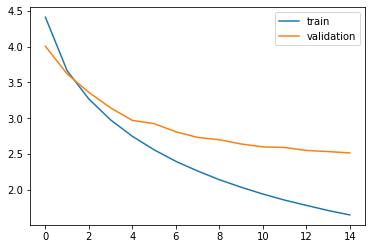

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

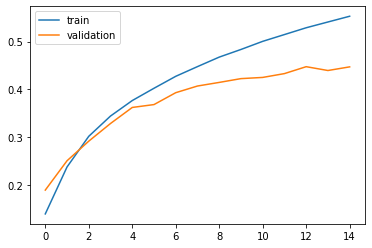

In [ ]:
# Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train','validation'])
plt.show()

Al igual que en los modelos anteriores, el overfitting es considerable. A partir de la epoch 4 comienza a ser problemático.

In [ ]:
model = load_model(filename)
preds = model.predict_classes(testX1.reshape((testX1.shape[0],testX1.shape[1])),batch_size=8)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [ ]:
pred_df = pd.DataFrame({'actual' : test.iloc[0:100,0], 'predicted' : preds_text})

In [ ]:
pd.set_option('display.max_colwidth', 200)

In [ ]:
pred_df.head(15)

,actual,predicted
43313,education starts at home,the is working in
22619,i wanna quit my job,i want my
48635,i dont have a flashlight,i dont have
39235,hold it with both hands,ill let for hands
23356,my sister is famous,my sister is very
27631,shes gone on a trip,she went him
51179,tom turned his lights off,tom turned off his
33033,we defeated the enemy,he happened the
30658,i just want the facts,i only want
15404,is somebody there,theres someone


In [ ]:
pred_df.tail(15)

,actual,predicted
21325,can i see you again,i can ask to
20085,tom has three cars,tom has three red
19261,my boots are dusty,my are years
50281,thatll be enough for now,thats will be for
13494,tom dont leave,i worry go tom
55520,tom wanted to protect mary,tom wanted to mary
36048,its strange isnt it,its is isnt
83660,lets start with something simple,lets start something long
2224,im not fat,i not feel
44355,i made a serious mistake,i made a mistake


In [ ]:
pred_df.sample(15)

,actual,predicted
13068,they were hungry,they were hungry
3526,let me think,let me
52985,i cant really describe it,i cant stop you
83660,lets start with something simple,lets start something long
46375,tom has three grown sons,tom has three children hours
2224,im not fat,i not feel
2031,i got angry,i got
2855,are you lost,are you
51179,tom turned his lights off,tom turned off his
36048,its strange isnt it,its is isnt


Este modelo tiene un desempeño similar al modelo GRU. El tiempo de entrenamiento es similar al caso del GRU (2s por paso frente a 3s por paso en el GRU)

La calidad de las traducciones es baja.

## Conclusión

Todos los modelos entrenados son susceptibles de ser mejorados con un fine-tuning adecuado. En todos los casos el overfitting ha supuesto un problema.

Para secuencias largas el LSTM rinde mejor que otros modelos. Para secuencias cortas GRU tiene un rendimiento similar o mejor que LSTM, siendo además más rápido de entrenar.